## DistilBERT Fine-Tuning 

In [25]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import *
import helpers as helpers
import torch.nn as nn

In [26]:
# DistilBERT: max_len=128–256, batch_size=16, lr≈2e-5, epochs=2–3, early stopping.

MODEL_NAME = "bert"

DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"
BERT_MODEL = 'distilbert-base-uncased'
N_GRAM = 2

MAX_LENGTH = 256
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

In [27]:
data, labels = helpers.get_data(datapath=DEPRESSION_PATH, ngram=N_GRAM, tokenize=False, by_character=False)
train_text, dev_text, test_text = helpers.split(data=data, dist=TDT_SPLIT)
train_dep, dev_dep, test_dep = helpers.split(data=labels, dist=TDT_SPLIT)

# convert data, labels into a pandas DataFrame
df = pd.DataFrame({'clean_text': data, 'is_depression': labels})

Completing 80/10/10 split
Completing 80/10/10 split


In [28]:
# Handles tokenization internally
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
bert = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# stats from tokenizers
print("Vocab length is : ",len(tokenizer.vocab))
print(tokenizer.decode(2897))

vocab = list(tokenizer.vocab.keys())
print(f"first 10: {vocab[:10]}")
print(f"1280-1290: {vocab[1280:1290]}")
print(f"last 10: {vocab[-10:]}")

print(f"token 2897: {tokenizer.decode(2897)}")
print(f"token 102: {tokenizer.decode(102)}")
print(f"token 103: {tokenizer.decode(103)}")
if 'alex' in tokenizer.vocab:
  print(f"alex id: {tokenizer.vocab['alex']}")
else:
  print("alex not found")

Vocab length is :  30522
network
first 10: ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]']
1280-1290: ['ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
last 10: ['##！', '##（', '##）', '##，', '##－', '##．', '##／', '##：', '##？', '##～']
token 2897: network
token 102: [SEP]
token 103: [MASK]
alex id: 4074


In [30]:
# tokenize train, dev, and test
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
dev_encodings = tokenizer(dev_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")

KeyboardInterrupt: 

In [ ]:
# custom dataset class
class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        return item
    
    def __len__(self):
        return len(self.labels)

In [ ]:
# Convert labels to tensors
train_labels = torch.tensor(train_dep)
dev_labels = torch.tensor(dev_dep)
test_labels = torch.tensor(test_dep)

# Create datasets using the custom class
train_dataset = DepressionDataset(train_encodings, train_labels)
dev_dataset = DepressionDataset(dev_encodings, dev_labels)
test_dataset = DepressionDataset(test_encodings, test_labels)

# Create DataLoaders (for manual training if needed)
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dl_dev = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
dl_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
optimizer = AdamW(bert.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions)
    }

In [ ]:
# begin training
# using hugging face built in trainer https://huggingface.co/blog/davidberenstein1957/fine-tune-modernbert-on-synthetic-data#:~:text=the%20training%20arguments.-,from%20huggingface_hub%20import%20HfFolder,-from%20transformers%20import

training_args = TrainingArguments(
    output_dir="./distilbert-depression-classifier",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=2e-5,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.217100,0.193975,0.913325,0.911493,0.945205,0.880102
2,0.145900,0.201959,0.924968,0.924479,0.944149,0.905612
3,0.078900,0.239184,0.928849,0.929215,0.937662,0.920918


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1161, training_loss=0.17071134565617893, metrics={'train_runtime': 596.3815, 'train_samples_per_second': 31.108, 'train_steps_per_second': 1.947, 'total_flos': 1228767589933056.0, 'train_loss': 0.17071134565617893, 'epoch': 3.0})

In [ ]:
def eval_model(predictions_output):
    # outputs prior to softmax
    pred_logits = predictions_output.predictions
    pred_probs = None

    # use softmax: logits -> probs 
    pred_probs = np.exp(pred_logits) / np.sum(np.exp(pred_logits), axis=1, keepdims=True)
    y_scores = pred_probs[:, 1] # prob of true class

    y_pred = np.argmax(pred_logits, axis=1)
    y_true = predictions_output.label_ids

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # pr_auc
    try:
        pr_auc = average_precision_score(y_true, y_scores)
    except ValueError:
        pr_auc = float('nan')

    # roc_auc
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        roc_auc = float('nan')

    return accuracy, precision, recall, f1, pr_auc, roc_auc

In [ ]:
# Get metrics to evaluate BERT Model

# generate predictions and outputs for dev
predictions_output_dev = trainer.predict(dev_dataset)
accuracy, precision, recall, f1, pr_auc, roc_auc = eval_model(predictions_output_dev)

print("Dev Dataset Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Dev Dataset Metrics
Accuracy: 0.9288
Precision: 0.9377
Recall: 0.9209
F1 Score: 0.9292
PR-AUC: 0.9847
ROC-AUC: 0.9805


In [ ]:
# evaluate our model on test
predictions_output_test = trainer.predict(test_dataset)
accuracy, precision, recall, f1, pr_auc, roc_auc = eval_model(predictions_output_test)

print("Test Dataset Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# save to csv 
csv_file_name = "results/results.csv"
row = [MODEL_NAME, precision, recall, f1, accuracy, pr_auc, roc_auc]

helpers.save_to_csv(csv_file_name, row)

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Dataset Metrics
Accuracy: 0.9302
Precision: 0.9297
Recall: 0.9247
F1 Score: 0.9272
PR-AUC: 0.9804
ROC-AUC: 0.9736
Data appended to results/results.csv


Plot saved: results/bert/confusion_dev_bert.png


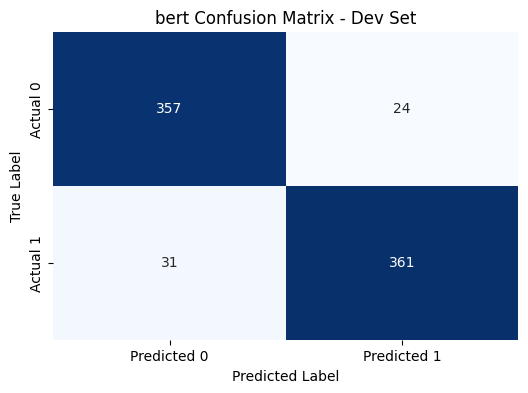

Plot saved: results/bert/confusion_test_bert.png


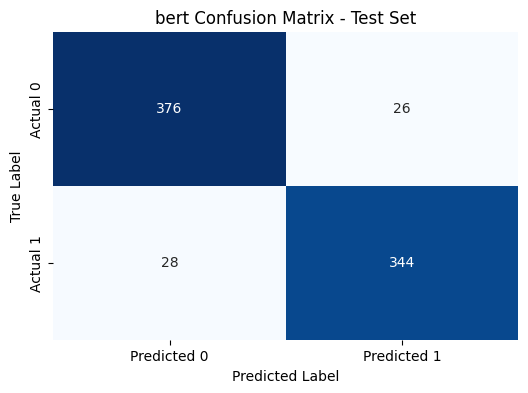

In [ ]:
# graphs

# Dev set confusion matrix
y_true_dev = [x['labels'] for x in dev_dataset]
y_pred_dev = predictions_output_dev.predictions.argmax(axis=1)

cm_dev = confusion_matrix(y_true_dev, y_pred_dev)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix - Dev Set')

file_name = f"results/{MODEL_NAME}/confusion_dev_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# Test set confusion matrix
y_true_test = [x['labels'] for x in test_dataset]
y_pred_test = predictions_output_test.predictions.argmax(axis=1)

cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix - Test Set')

file_name = f"results/{MODEL_NAME}/confusion_test_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

Plot saved: results/bert/pr_test_bert.png


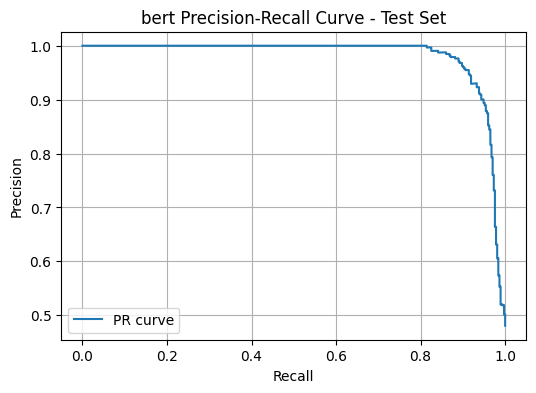

Plot saved: results/bert/pr_dev_bert.png


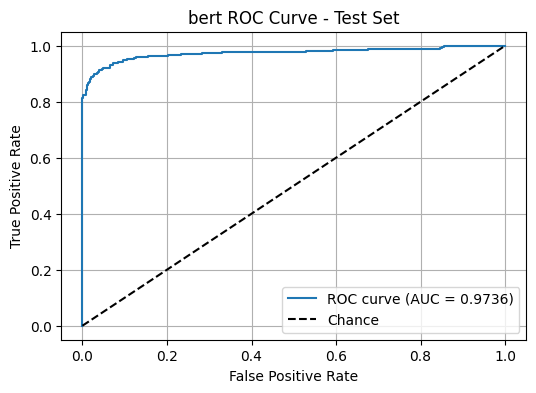

Plot saved: results/bert/learning_curve_bert.png


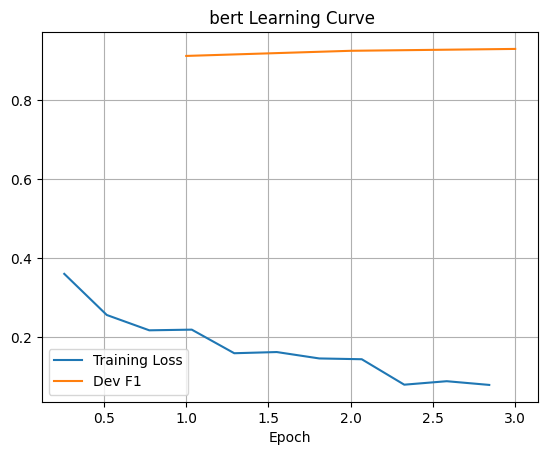

In [ ]:
# Precision-Recall curve for Test Set

# We need the true labels and predicted probabilities for the positive class
y_true_test = [x['labels'] for x in test_dataset]
if hasattr(predictions_output_test, "probabilities"):
    # HuggingFace >= v4.35.0
    y_scores_test = predictions_output_test.probabilities[:,1]
else:
    # fallback to logits
    y_scores_test = torch.softmax(torch.tensor(predictions_output_test.predictions), dim=1)[:,1].numpy()

precision, recall, pr_thresholds = precision_recall_curve(y_true_test, y_scores_test)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{MODEL_NAME} Precision-Recall Curve - Test Set')
plt.grid()
plt.legend()

file_name = f"results/{MODEL_NAME}/pr_test_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# ROC curve for Test Set
fpr, tpr, roc_thresholds = roc_curve(y_true_test, y_scores_test)
roc_auc = roc_auc_score(y_true_test, y_scores_test)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{MODEL_NAME} ROC Curve - Test Set')
plt.grid()
plt.legend()

file_name = f"results/{MODEL_NAME}/pr_dev_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# Learning curve: training loss and dev F1 vs. epoch
training_logs = []
dev_f1s = []
epochs = []

if hasattr(trainer, "state") and hasattr(trainer.state, "log_history"):
    log_history = trainer.state.log_history
else:
    log_history = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        training_logs.append((log["epoch"], log["loss"]))
    if "eval_f1" in log and "epoch" in log:
        dev_f1s.append((log["epoch"], log["eval_f1"]))

if training_logs:
    train_loss_df = pd.DataFrame(training_logs, columns=['epoch', 'train_loss'])
    train_loss_df = train_loss_df.groupby('epoch').mean().reset_index()
    plt.plot(train_loss_df['epoch'], train_loss_df['train_loss'], label="Training Loss")
if dev_f1s:
    dev_f1_df = pd.DataFrame(dev_f1s, columns=['epoch', 'dev_f1'])
    dev_f1_df = dev_f1_df.groupby('epoch').max().reset_index()
    plt.plot(dev_f1_df['epoch'], dev_f1_df['dev_f1'], label="Dev F1")

plt.xlabel("Epoch")
plt.title(f" {MODEL_NAME} Learning Curve")
plt.legend()
plt.grid()

file_name = f"results/{MODEL_NAME}/learning_curve_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

Plot saved: results/bert/most_bert.png


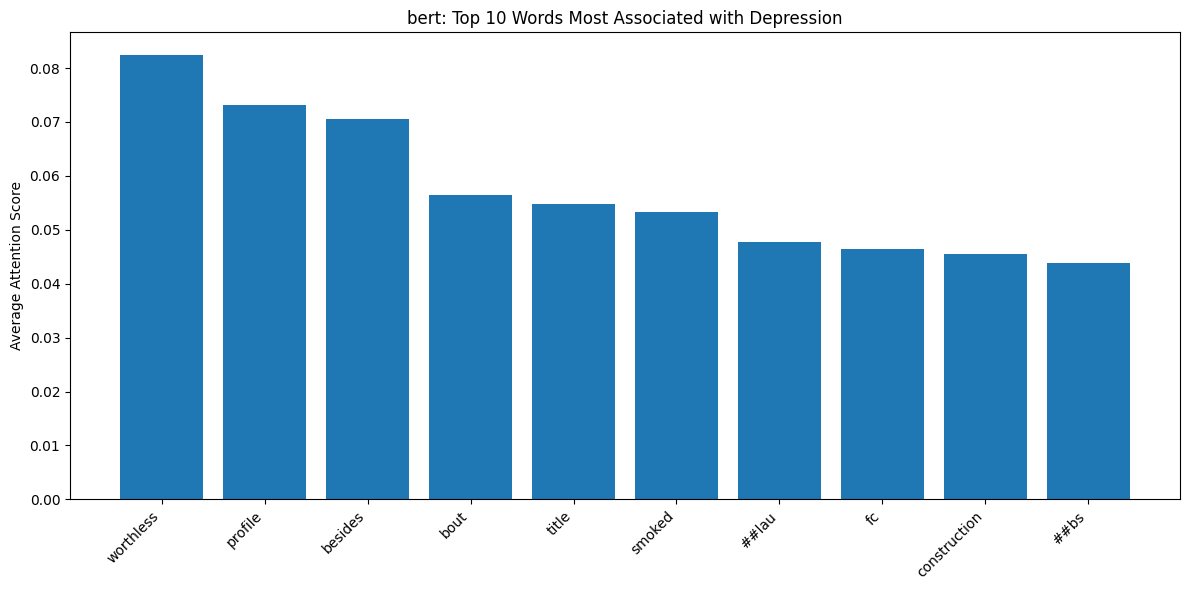

Plot saved: results/bert/least_bert.png


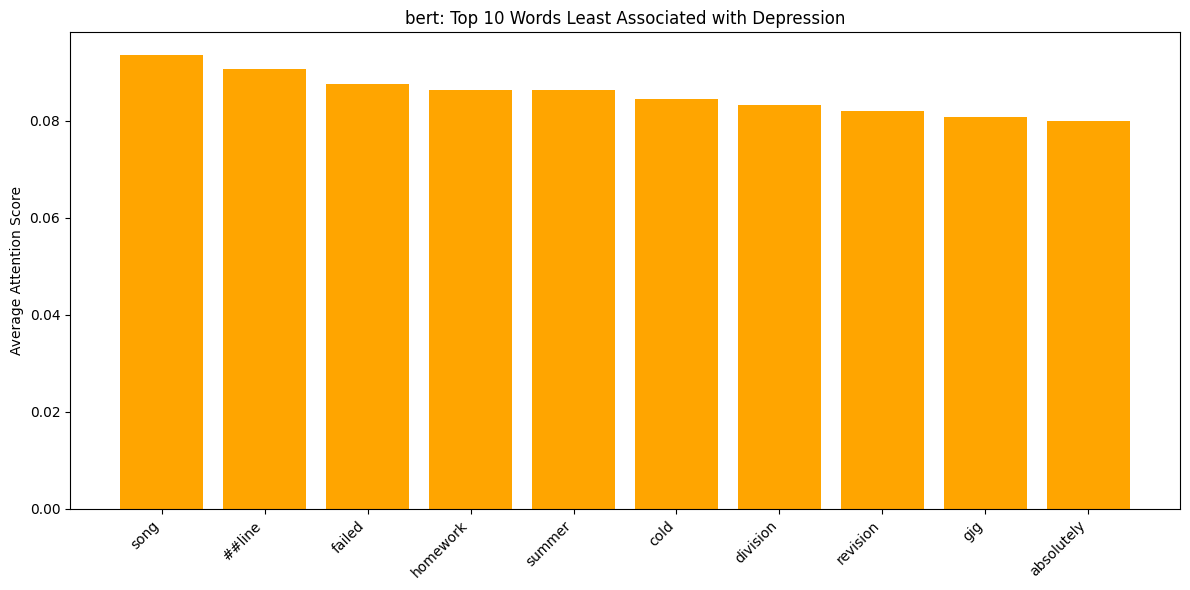

In [32]:
# Add this cell to your bert.ipynb after model training

import torch.nn.functional as F
from collections import defaultdict

def get_attention_weights(model, tokenizer, texts, device='cpu'):
    """
    Extract attention weights from BERT for given texts.
    Returns token-level importance scores.
    """
    model.eval()
    token_importance = defaultdict(float)
    token_counts = defaultdict(int)

    with torch.no_grad():
        for text in texts[:100]:  # Sample 100 examples for efficiency
            # Tokenize
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                max_length=MAX_LENGTH,
                padding=True
            ).to(device)

            # Get model outputs with attention
            outputs = model(**inputs, output_attentions=True)
            attentions = outputs.attentions  # List of attention tensors

            # Average attention across all layers and heads
            # attentions shape: (num_layers, batch_size, num_heads, seq_len, seq_len)
            avg_attention = torch.stack(attentions).mean(dim=(0, 2))  # Average over layers and heads
            # Shape: (batch_size, seq_len, seq_len)

            # Get attention to [CLS] token (first token) - represents overall importance
            cls_attention = avg_attention[0, 0, :]  # Attention from CLS to all tokens

            # Get tokens
            tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

            # Accumulate importance scores
            for token, score in zip(tokens, cls_attention.cpu().numpy()):
                if token not in ['[CLS]', '[SEP]', '[PAD]']:
                    token_importance[token] += score
                    token_counts[token] += 1

    # Average importance scores
    avg_importance = {token: token_importance[token] / token_counts[token]
                     for token in token_importance}

    return avg_importance

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(device)

# Get attention weights for depression examples
depression_texts = [text for text, label in zip(test_text, test_dep) if label == 1][:100]
non_depression_texts = [text for text, label in zip(test_text, test_dep) if label == 0][:100]

depression_importance = get_attention_weights(bert, tokenizer, depression_texts, device)
non_depression_importance = get_attention_weights(bert, tokenizer, non_depression_texts, device)

# Get top k most important tokens for depression
k = 10
sorted_dep = sorted(depression_importance.items(), key=lambda x: x[1], reverse=True)[:k]
sorted_non_dep = sorted(non_depression_importance.items(), key=lambda x: x[1], reverse=True)[:k]

# =================================================
# top k words MOST associated with depression
# =================================================
tokens_dep, scores_dep = zip(*sorted_dep)
plt.figure(figsize=(12, 6))
plt.bar(range(len(tokens_dep)), scores_dep)
plt.xticks(range(len(tokens_dep)), tokens_dep, rotation=45, ha='right')
plt.ylabel('Average Attention Score')
plt.title(f'{MODEL_NAME}: Top {k} Words Most Associated with Depression')
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/most_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# =================================================
# top k words LEAST associated with depression
# =================================================
tokens_non_dep, scores_non_dep = zip(*sorted_non_dep)
plt.figure(figsize=(12, 6))
plt.bar(range(len(tokens_non_dep)), scores_non_dep, color='orange')
plt.xticks(range(len(tokens_non_dep)), tokens_non_dep, rotation=45, ha='right')
plt.ylabel('Average Attention Score')
plt.title(f'{MODEL_NAME}: Top {k} Words Least Associated with Depression')
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/least_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()